In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Load and preprocess the data
data = pd.read_csv("merged_datasets.csv",header="infer")
data = data.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
data = data.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})


In [6]:
# Identify the number of unique shots and split the data into training and testing sets
numShots = data["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = data.loc[data["SHOT_ID"]<= trainsetSize]
testdata = data.loc[data["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())

448
313
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
44351      314  4.051489  2.010944  2.685567
44352      314  4.098172  2.020867  2.768408
44353      314  4.148763  2.031621  2.852487
44354      314  4.199231  2.042348  2.933508
44355      314  4.247574  2.052623  3.014149


In [7]:
# Scale the features between 0 and 1 for training and testing data
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

   SHOT_ID         X    Y         Z
0        1  0.005323  0.0  0.247623
1        1  0.019561  0.0  0.257403
2        1  0.033880  0.0  0.267392
3        1  0.047509  0.0  0.276407
4        1  0.061433  0.0  0.285703
       SHOT_ID         X         Y         Z
44351      314  0.000880  0.000000  0.403728
44352      314  0.010269  0.001424  0.416922
44353      314  0.020443  0.002966  0.430313
44354      314  0.030593  0.004505  0.443217
44355      314  0.040315  0.005980  0.456061


C:\Users\xunth\AppData\Local\Temp\ipykernel_24360\1693180516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
C:\Users\xunth\AppData\Local\Temp\ipykernel_24360\1693180516.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])


In [8]:
# Function to prepare sequences of data for each shot
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique():
        shot_data = data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values
        for i in range(len(shot_data) - sequence_length):
            sequence = shot_data[i:i+sequence_length]
            X.append(sequence)
            Y.append(shot_data[i+sequence_length])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Prepare the training and testing data
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)
print(X_train.dtype,Y_train.dtype)

X_test, Y_test = prepare_data(testdata, sequence_length)
print(X_test)

float64 float64
[[[8.80350025e-04 0.00000000e+00 4.03728054e-01]
  [1.02687745e-02 1.42362478e-03 4.16922017e-01]
  [2.04432181e-02 2.96643855e-03 4.30313133e-01]
  ...
  [1.17453373e-01 1.76766878e-02 5.49606784e-01]
  [1.27072260e-01 1.91352590e-02 5.60183083e-01]
  [1.36677414e-01 2.05917479e-02 5.70991242e-01]]

 [[1.02687745e-02 1.42362478e-03 4.16922017e-01]
  [2.04432181e-02 2.96643855e-03 4.30313133e-01]
  [3.05928231e-02 4.50548591e-03 4.43217304e-01]
  ...
  [1.27072260e-01 1.91352590e-02 5.60183083e-01]
  [1.36677414e-01 2.05917479e-02 5.70991242e-01]
  [1.45514958e-01 2.19318394e-02 5.81344206e-01]]

 [[2.04432181e-02 2.96643855e-03 4.30313133e-01]
  [3.05928231e-02 4.50548591e-03 4.43217304e-01]
  [4.03152243e-02 5.97975364e-03 4.56060927e-01]
  ...
  [1.36677414e-01 2.05917479e-02 5.70991242e-01]
  [1.45514958e-01 2.19318394e-02 5.81344206e-01]
  [1.54600158e-01 2.33094844e-02 5.92019538e-01]]

 ...

 [[9.39497243e-01 9.39133402e-01 5.33562480e-01]
  [9.43437359e-01 9.418

In [9]:
# Reshape the input data to a 2D array for RandomForestRegressor
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

# Create a Random Forest Regressor
rfModel = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rfModel.fit(X_train, Y_train)

# Make predictions
Y_pred = rfModel.predict(X_test)


In [10]:
# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2)

Mean Squared Error: 0.0010897586034812389
Root Mean Squared Error: 0.033011491991142096
Mean Absolute Error: 0.022139644064178825
R-squared: 0.9806071937569018


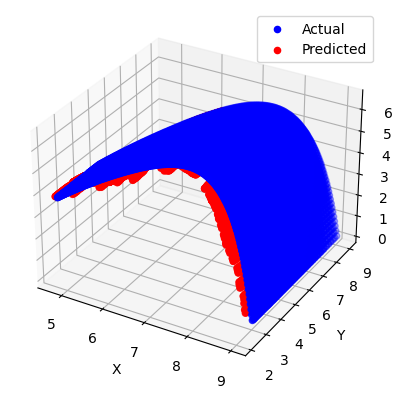

In [11]:
# Make predictions
Y_pred = rfModel.predict(X_test)

# Convert predictions back to original scale for plotting
Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()